In [1]:
#https://ieeexplore.ieee.org/document/10549889

In [2]:
!pip install openpyxl ssqueezepy

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# !pip install --upgrade tensorflow

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.applications import ResNet50
from ssqueezepy import cwt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt
import pywt
import matplotlib.pyplot as plt

2024-12-09 17:49:24.246985: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 17:49:24.247090: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 17:49:24.247137: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 17:49:24.257818: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import keras.models
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [6]:
# Load datasets
ppg_data_combined = pd.read_excel('combined_dataset.xlsx')

print(ppg_data_combined)

     Num.  subject_ID Sex(M/F)  Age(year)  Height(cm)  Weight(kg)  \
0       1           2   Female         45         152          63   
1       1           2   Female         45         152          63   
2       1           2   Female         45         152          63   
3       2           3   Female         50         157          50   
4       2           3   Female         50         157          50   
..    ...         ...      ...        ...         ...         ...   
652   218         418     Male         25         173          63   
653   218         418     Male         25         173          63   
654   219         419     Male         24         175          58   
655   219         419     Male         24         175          58   
656   219         419     Male         24         175          58   

     Systolic Blood Pressure(mmHg)  Diastolic Blood Pressure(mmHg)  \
0                              161                              89   
1                              

In [7]:
# 참가자의 숫자 확인
print(ppg_data_combined['subject_ID'].nunique())

219


The dataset provided by Liang et al. in their study is a valuable resource for non-invasive CVD detection, encompassing 657 data segments from 219 individuals.

In [8]:
data_systolic = ppg_data_combined["Systolic Blood Pressure(mmHg)"]
data_diastolic = ppg_data_combined["Diastolic Blood Pressure(mmHg)"]

ppg_data = ppg_data_combined.iloc[:,14:]

In [9]:
ppg_data = np.array(ppg_data)
print(ppg_data)

[[2438 2438 2438 ... 1827 1754 1754]
 [2201 2201 2171 ... 1997 1997 1997]
 [2019 2014 2014 ... 1924 1929 1929]
 ...
 [3083 3039 3071 ... 2422 2451 2379]
 [2426 2431 2446 ... 3103 3146 3151]
 [2691 2718 2743 ... 2611 2639 2623]]


In [10]:
# Assuming bp_data has columns 'systolic' and 'diastolic'
# Normalize blood pressure data
bp_data = np.array([data_systolic, data_diastolic]).T
print(bp_data)

[[161  89]
 [161  89]
 [161  89]
 ...
 [108  68]
 [108  68]
 [108  68]]


In [11]:
print(ppg_data.shape)
print(bp_data.shape)

(657, 2100)
(657, 2)


### 이상치 제거를 위한 Bandpass Filter와 Wavelet 변환

In [12]:
# Define Bandpass Filter
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data, axis=1)  # Filter along each row
    return filtered_data

In [13]:
# Define Wavelet Denoising
def denoise_wavelet(data, wavelet='db4', level=4):
    denoised_data = []
    for row in data:
        coeffs = pywt.wavedec(row, wavelet, mode='per')
        # Thresholding to remove noise
        for i in range(1, len(coeffs)):
            coeffs[i] = pywt.threshold(coeffs[i], value=np.std(coeffs[i]) * 0.5, mode='soft')
        denoised_row = pywt.waverec(coeffs, wavelet, mode='per')
        denoised_data.append(denoised_row[:len(row)])  # Trim to original length
    return np.array(denoised_data)

In [14]:
# Sampling frequency (Hz)
fs = 1000  # Assumed sampling frequency, adjust as per your data
lowcut = 0.5  # Minimum frequency (Hz)
highcut = 15.0  # Maximum frequency (Hz)

# Apply Bandpass Filter
ppg_bandpassed = bandpass_filter(ppg_data, lowcut, highcut, fs)

# Apply Wavelet Denoising
ppg_denoised = denoise_wavelet(ppg_bandpassed)

print("Shape after filtering:", ppg_denoised.shape)

Shape after filtering: (657, 2100)


### 원본 PPG와 잡음 제거 후 PPG 시각화

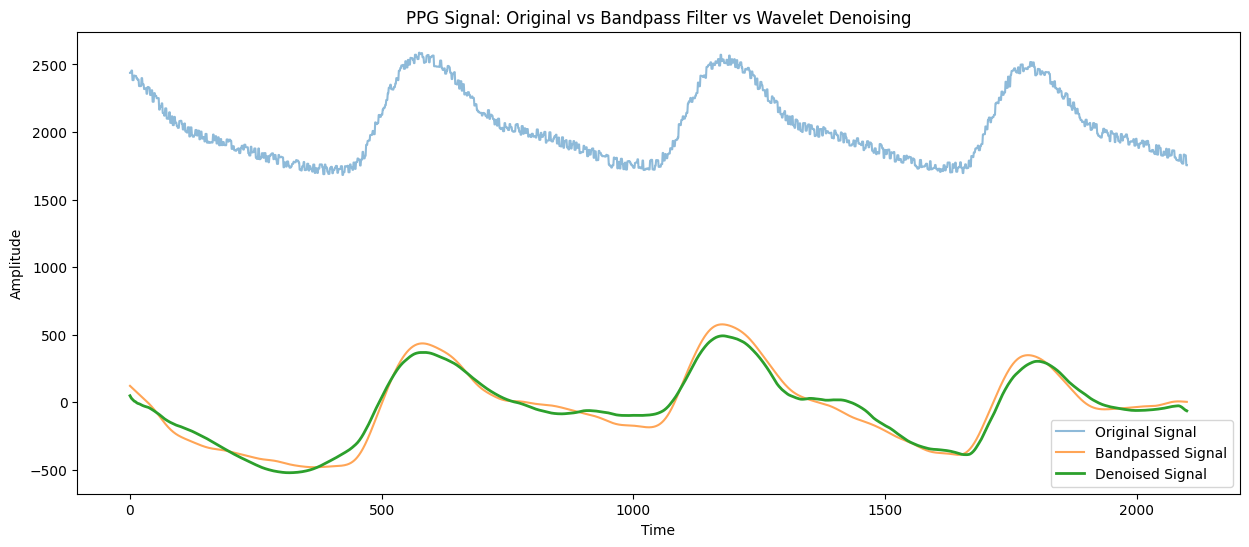

In [15]:
# Visualize original, filtered, and denoised data for a single PPG signal
sample_index = 0  # Choose a sample row to visualize

plt.figure(figsize=(15, 6))
plt.plot(ppg_data[sample_index], label="Original Signal", alpha=0.5)
plt.plot(ppg_bandpassed[sample_index], label="Bandpassed Signal", alpha=0.7)
plt.plot(ppg_denoised[sample_index], label="Denoised Signal", linewidth=2)
plt.legend()
plt.title("PPG Signal: Original vs Bandpass Filter vs Wavelet Denoising")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [16]:
# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(ppg_denoised, bp_data, test_size=0.2, random_state=42)

print("Train/Test Split:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Train/Test Split:
X_train shape: (525, 2100), y_train shape: (525, 2)
X_test shape: (132, 2100), y_test shape: (132, 2)


In [17]:
# PPG Signal (2100, 1)으로 변환
X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train_lstm = y_train
y_test_lstm = y_test

In [18]:
# Perform CWT transform
def CWT_transform(data):
    from ssqueezepy import cwt
    images = []
    for signal in data:
        Wx, _ = cwt(signal, wavelet='morlet')
        Wx = np.abs(Wx)
        Wx = (Wx - Wx.min()) / (Wx.max() - Wx.min())
        images.append(Wx)
    return np.array(images)

X_train_cwt = CWT_transform(X_train)
X_test_cwt = CWT_transform(X_test)
X_train_cwt = np.array([tf.image.resize(img[..., np.newaxis], [128, 128]).numpy() for img in X_train_cwt])
X_test_cwt = np.array([tf.image.resize(img[..., np.newaxis], [128, 128]).numpy() for img in X_test_cwt])

# Adjust shapes
X_train_cwt = X_train_cwt[:X_train_lstm.shape[0]]
X_test_cwt = X_test_cwt[:X_test_lstm.shape[0]]

/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
2024-12-09 17:51:14.425720: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38698 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:0b:00.0, compute capability: 8.0
2024-12-09 17:51:14.428088: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38698 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:4c:00.0, compute capability: 8.0


In [19]:
# Debug final shapes
print("After Slicing:")
print(f"X_train_cwt shape: {X_train_cwt.shape}, X_train_lstm shape: {X_train_lstm.shape}")
print(f"y_train_lstm shape: {y_train_lstm.shape}")

After Slicing:
X_train_cwt shape: (525, 128, 128, 1), X_train_lstm shape: (525, 2100, 1)
y_train_lstm shape: (525, 2)


In [20]:
# 1D 데이터 증강
def time_warping(data, scale_range=(0.9, 1.1)):
    """Time warping by scaling the time axis."""
    augmented_data = []
    for signal in data:
        scale = np.random.uniform(scale_range[0], scale_range[1])
        # Resample the signal
        warped_signal = np.interp(np.arange(0, len(signal), scale), np.arange(0, len(signal)), signal)
        # Trim or pad to match the original length
        if len(warped_signal) > len(signal):
            warped_signal = warped_signal[:len(signal)]
        else:
            warped_signal = np.pad(warped_signal, (0, len(signal) - len(warped_signal)), 'constant')
        augmented_data.append(warped_signal)
    return np.array(augmented_data)


def amplitude_scaling(data, scale_range=(0.8, 1.2)):
    """Scale the amplitude of the signal."""
    scale_factors = np.random.uniform(scale_range[0], scale_range[1], size=(data.shape[0], 1))
    return data * scale_factors

def add_jitter(data, noise_level=0.01):
    """Add random Gaussian noise to the signal."""
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise



In [21]:
# 2D 데이터 증강
def rotate_image(image, angle_range=(-15, 15)):
    """Randomly rotate the image within the specified angle range."""
    angle = np.random.uniform(angle_range[0], angle_range[1])
    return tf.image.rot90(image, k=int(angle / 90))

def flip_image(image):
    """Randomly flip the image horizontally and vertically."""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

def shift_image(image, max_shift=5):
    """Randomly shift the image."""
    translations = [np.random.randint(-max_shift, max_shift) for _ in range(2)]
    return tf.image.pad_to_bounding_box(image, max(0, translations[0]), max(0, translations[1]), image.shape[0] + max_shift, image.shape[1] + max_shift)


In [22]:
# Augment PPG data (LSTM input)
augmented_time_warp = time_warping(X_train_lstm[:, :, 0])  # Remove the channel dimension for augmentation
augmented_amplitude = amplitude_scaling(X_train_lstm[:, :, 0])
augmented_jitter = add_jitter(X_train_lstm[:, :, 0])

# Combine augmented data and original data
X_train_lstm = np.concatenate([X_train_lstm[:, :, 0], augmented_time_warp, augmented_amplitude, augmented_jitter], axis=0)
X_train_lstm = X_train_lstm[..., np.newaxis]  # Add channel dimension back

# Repeat labels for augmented data
y_train_lstm = np.concatenate([y_train_lstm, y_train_lstm, y_train_lstm, y_train_lstm], axis=0)

# Augment CWT images (CNN input)
# Ensure all augmented images have the same size
augmented_images = []
for img in X_train_cwt:
    rotated_img = rotate_image(img)
    flipped_img = flip_image(img)
    shifted_img = shift_image(img)
    
    # Resize augmented images to match the original image size
    rotated_img = tf.image.resize(rotated_img, [128, 128]).numpy()
    flipped_img = tf.image.resize(flipped_img, [128, 128]).numpy()
    shifted_img = tf.image.resize(shifted_img, [128, 128]).numpy()
    
    augmented_images.extend([rotated_img, flipped_img, shifted_img])

augmented_images = np.array(augmented_images)
# Combine augmented images and original data
X_train_cwt = np.concatenate([X_train_cwt, augmented_images], axis=0)

# Repeat labels for augmented images
y_train_lstm = np.concatenate([y_train_lstm, y_train_lstm, y_train_lstm], axis=0)

In [40]:
print(f"Original image shape: {X_train_cwt.shape[1:]}")
print(f"Augmented image shape: {augmented_images.shape[1:]}")

Original image shape: (128, 128, 1)
Augmented image shape: (128, 128, 1)


In [23]:
# Custom Loss Function
def custom_loss(y_true, y_pred):
    sbp_true, dbp_true = y_true[:, 0], y_true[:, 1]
    sbp_pred, dbp_pred = y_pred[:, 0], y_pred[:, 1]
    sbp_loss = tf.keras.losses.Huber(delta=10)(sbp_true, sbp_pred)
    dbp_loss = tf.keras.losses.Huber(delta=5)(dbp_true, dbp_pred)
    return 0.6 * sbp_loss + 0.4 * dbp_loss

In [24]:
# Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [25]:
# Transformer Model
def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, dropout=0.3):
    inputs = layers.Input(shape=input_shape, name="Transformer_Input")
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = layers.GlobalAveragePooling1D()(x)
    return inputs, x

In [26]:
# Multi-Head Attention for CNN and Transformer
def cross_attention(cnn_features, transformer_features, num_heads=8):
    """
    Apply Multi-Head Attention between CNN and Transformer outputs.
    """
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=cnn_features.shape[-1]
    )(query=cnn_features, key=transformer_features, value=transformer_features)
    
    # Add residual connection
    attention_output = layers.Add()([cnn_features, attention_output])
    attention_output = layers.LayerNormalization()(attention_output)
    return attention_output

In [27]:
# 상위 하위 10개 층 fineTuning
def build_combined_attention_model(cnn_input_shape, transformer_input_shape, transformer_params, output_dim=2):
    # CNN Branch
    cnn_inputs = layers.Input(shape=cnn_input_shape, name="CNN_Input")
    
    # Pre-trained ResNet50 (RGB channels replicated from single-channel input)
    replicated_inputs = layers.Concatenate()([cnn_inputs, cnn_inputs, cnn_inputs])
    base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=replicated_inputs)
    
    # Freeze all layers first
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze the top layers for fine-tuning
    for layer in base_model.layers[-10:]:  # Unfreeze the last 10 layers
        layer.trainable = True

    # Global Average Pooling and Dense Layers
    cnn_features = layers.GlobalAveragePooling2D()(base_model.output)
    cnn_features = layers.Dense(128, activation="relu")(cnn_features)
    
    # Transformer Branch
    transformer_inputs = layers.Input(shape=transformer_input_shape, name="Transformer_Input")
    x = transformer_inputs
    for _ in range(transformer_params["num_transformer_blocks"]):
        x = transformer_encoder(x, transformer_params["head_size"], transformer_params["num_heads"],
                                 transformer_params["ff_dim"], transformer_params["dropout"])
    transformer_features = layers.GlobalAveragePooling1D()(x)
    
    # Cross-Attention between CNN and Transformer
    attention_output = cross_attention(cnn_features[:, tf.newaxis, :], transformer_features[:, tf.newaxis, :])
    attention_output = layers.Flatten()(attention_output)
    
    # Fully Connected Layers
    x = layers.Dense(128, activation="relu")(attention_output)  # 첫 번째 FC 층
    x = layers.Dropout(0.3)(x)  # 과적합 방지를 위한 Dropout
    x = layers.Dense(64, activation="relu")(x)  # 두 번째 FC 층
    x = layers.Dropout(0.3)(x)  # Dropout 추가
    x = layers.Dense(32, activation="relu")(x)  # 세 번째 FC 층
    x = layers.Dropout(0.3)(x)  # Dropout 추가
    outputs = layers.Dense(output_dim, activation="linear", name="BP_Output")(x)  # 출력층

    
    # Define the model
    model = Model(inputs=[cnn_inputs, transformer_inputs], outputs=outputs)
    return model

In [ ]:
# # 전체 fine Tuning
# def build_combined_attention_model(cnn_input_shape, transformer_input_shape, transformer_params, output_dim=2):
#     # CNN Branch
#     cnn_inputs = layers.Input(shape=cnn_input_shape, name="CNN_Input")
    
#     # Pre-trained ResNet50 (RGB channels replicated from single-channel input)
#     replicated_inputs = layers.Concatenate()([cnn_inputs, cnn_inputs, cnn_inputs])  # Convert 1 channel to 3 channels
#     base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=replicated_inputs)
    
#     # Unfreeze all layers for full fine-tuning
#     for layer in base_model.layers:
#         layer.trainable = True  # Fine-tune all layers

#     # Global Average Pooling and Dense Layers
#     cnn_features = layers.GlobalAveragePooling2D()(base_model.output)
#     cnn_features = layers.Dense(128, activation="relu")(cnn_features)
    
#     # Transformer Branch
#     transformer_inputs = layers.Input(shape=transformer_input_shape, name="Transformer_Input")
#     x = transformer_inputs
#     for _ in range(transformer_params["num_transformer_blocks"]):
#         x = transformer_encoder(x, transformer_params["head_size"], transformer_params["num_heads"],
#                                  transformer_params["ff_dim"], transformer_params["dropout"])
#     transformer_features = layers.GlobalAveragePooling1D()(x)
    
#     # Cross-Attention between CNN and Transformer
#     attention_output = cross_attention(cnn_features[:, tf.newaxis, :], transformer_features[:, tf.newaxis, :])
#     attention_output = layers.Flatten()(attention_output)
    
#     # Fully Connected Layers
#     x = layers.Dense(128, activation="relu")(attention_output)  # 첫 번째 FC 층
#     x = layers.Dropout(0.3)(x)  # 과적합 방지를 위한 Dropout
#     x = layers.Dense(64, activation="relu")(x)  # 두 번째 FC 층
#     x = layers.Dropout(0.3)(x)  # Dropout 추가
#     x = layers.Dense(32, activation="relu")(x)  # 세 번째 FC 층
#     x = layers.Dropout(0.3)(x)  # Dropout 추가
#     outputs = layers.Dense(output_dim, activation="linear", name="BP_Output")(x)  # 출력층
    
#     # Define the model
#     model = Model(inputs=[cnn_inputs, transformer_inputs], outputs=outputs)
#     return model


In [28]:
# # CNN and Transformer Combined Model with Attention
# def build_combined_attention_model(cnn_input_shape, transformer_input_shape, transformer_params, output_dim=2):
#     # CNN Branch
#     cnn_inputs = layers.Input(shape=cnn_input_shape, name="CNN_Input")
    
#     # Pre-trained ResNet50 (RGB channels replicated from single-channel input)
#     replicated_inputs = layers.Concatenate()([cnn_inputs, cnn_inputs, cnn_inputs])
#     base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=replicated_inputs)
#     cnn_features = layers.GlobalAveragePooling2D()(base_model.output)
    
#     # Dense layer to reduce feature dimension
#     cnn_features = layers.Dense(128, activation="relu")(cnn_features)
    
#     # Transformer Branch
#     transformer_inputs = layers.Input(shape=transformer_input_shape, name="Transformer_Input")
#     x = transformer_inputs
#     for _ in range(transformer_params["num_transformer_blocks"]):
#         x = transformer_encoder(x, transformer_params["head_size"], transformer_params["num_heads"],
#                                  transformer_params["ff_dim"], transformer_params["dropout"])
#     transformer_features = layers.GlobalAveragePooling1D()(x)
    
#     # Cross-Attention between CNN and Transformer
#     attention_output = cross_attention(cnn_features[:, tf.newaxis, :], transformer_features[:, tf.newaxis, :])
#     attention_output = layers.Flatten()(attention_output)
    
#     # Fully Connected Layers
#     x = layers.Dense(128, activation="relu")(attention_output)  # 첫 번째 FC 층
#     x = layers.Dropout(0.3)(x)  # 과적합 방지를 위한 Dropout
#     x = layers.Dense(64, activation="relu")(x)  # 두 번째 FC 층
#     x = layers.Dropout(0.3)(x)  # Dropout 추가
#     x = layers.Dense(32, activation="relu")(x)  # 세 번째 FC 층
#     x = layers.Dropout(0.3)(x)  # Dropout 추가
#     outputs = layers.Dense(output_dim, activation="linear", name="BP_Output")(x)  # 출력층

    
#     # Define the model
#     model = Model(inputs=[cnn_inputs, transformer_inputs], outputs=outputs)
#     return model

In [29]:
# Transformer Parameters
transformer_params = {
    "head_size": 64,
    "num_heads": 4,
    "ff_dim": 4,
    "num_transformer_blocks": 3,
    "dropout": 0.3,
}

# Define input shapes
cnn_input_shape = (128, 128, 1)  # Single-channel input
transformer_input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])

# Build the model
model = build_combined_attention_model(cnn_input_shape, transformer_input_shape, transformer_params)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=custom_loss, metrics=['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 CNN_Input (InputLayer)      [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 128, 128, 3)          0         ['CNN_Input[0][0]',           
                                                                     'CNN_Input[0][0]',           
                                                                     'CNN_Input[0][0]']           
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['concatenate[0][0]']         
                                                                                              

                                                                     'conv2_block2_3_bn[0][0]']   
                                                                                                  
 conv2_block2_out (Activati  (None, 32, 32, 256)          0         ['conv2_block2_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 32, 32, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 32, 32, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv3_block2_2_bn (BatchNo  (None, 16, 16, 128)          512       ['conv3_block2_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_2_relu (Activ  (None, 16, 16, 128)          0         ['conv3_block2_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 16, 16, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 16, 16, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv4_block1_1_relu (Activ  (None, 8, 8, 256)            0         ['conv4_block1_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_2_conv (Conv2  (None, 8, 8, 256)            590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 8, 8, 256)            1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 rmalization)                                                                                     
                                                                                                  
 conv4_block3_add (Add)      (None, 8, 8, 1024)           0         ['conv4_block2_out[0][0]',    
                                                                     'conv4_block3_3_bn[0][0]']   
                                                                                                  
 conv4_block3_out (Activati  (None, 8, 8, 1024)           0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 8, 8, 256)            262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
          

 conv4_block6_2_relu (Activ  (None, 8, 8, 256)            0         ['conv4_block6_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block6_3_conv (Conv2  (None, 8, 8, 1024)           263168    ['conv4_block6_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 8, 8, 1024)           4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 8, 8, 1024)           0         ['conv4_block5_out[0][0]',    
          

 tf.__operators__.add_1 (TF  (None, 2100, 1)              0         ['layer_normalization_1[0][0]'
 OpLambda)                                                          , 'tf.__operators__.add[0][0]'
                                                                    ]                             
                                                                                                  
 conv5_block2_2_conv (Conv2  (None, 4, 4, 512)            2359808   ['conv5_block2_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 multi_head_attention_1 (Mu  (None, 2100, 1)              1793      ['tf.__operators__.add_1[0][0]
 ltiHeadAttention)                                                  ',                            
                                                                     'tf.__operators__.add_1[0][0]
          

 tf.__operators__.add_4 (TF  (None, 2100, 1)              0         ['layer_normalization_4[0][0]'
 OpLambda)                                                          , 'tf.__operators__.add_3[0][0
                                                                    ]']                           
                                                                                                  
 conv5_block3_3_conv (Conv2  (None, 4, 4, 2048)           1050624   ['conv5_block3_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv1d_4 (Conv1D)           (None, 2100, 4)              8         ['tf.__operators__.add_4[0][0]
                                                                    ']                            
                                                                                                  
 conv5_blo

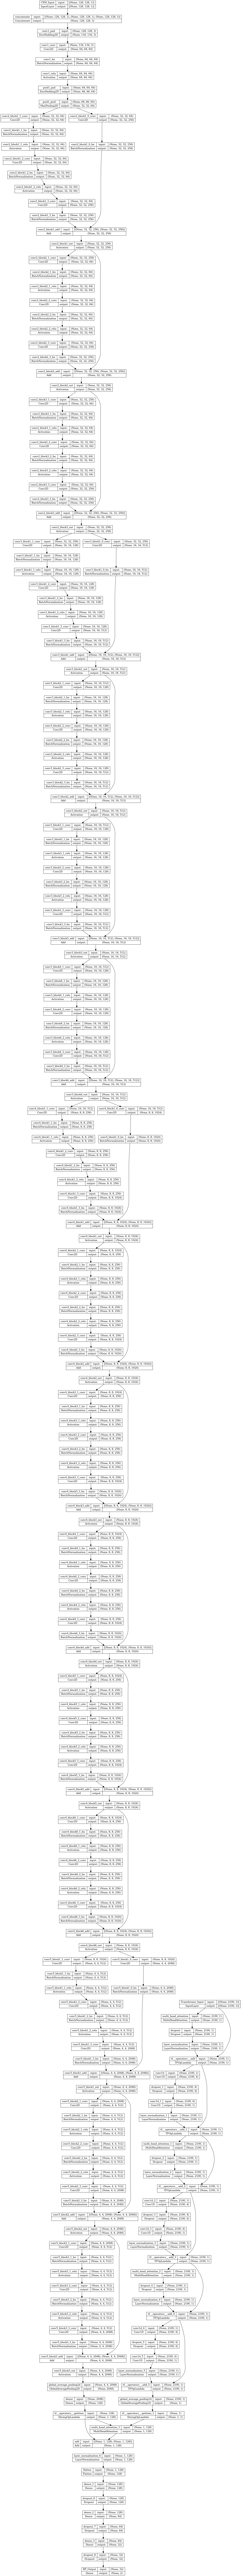

In [30]:
from tensorflow.keras.utils import plot_model

# 모델 시각화
plot_model(
    model,                   # 학습에 사용된 모델
    to_file="model_plot.png",  # 저장할 파일 이름
    show_shapes=True,         # 각 레이어의 출력 텐서 모양 표시
    show_layer_names=True,    # 레이어 이름 표시
    expand_nested=True,       # 중첩된 모델 (서브모델) 시각화
    dpi=96                    # 해상도 설정
)

In [31]:
# Pretraining
history_pretrain = model.fit(
    {"CNN_Input": X_train_cwt, "Transformer_Input": X_train_lstm},
    y_train_lstm,
    validation_split=0.2,
    epochs=50,  # Pretraining for a few epochs
    batch_size=32
)

Epoch 1/50


2024-12-09 17:51:28.945009: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-12-09 17:51:30.411090: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa33c09a8d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-09 17:51:30.411152: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2024-12-09 17:51:30.411162: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2024-12-09 17:51:30.416801: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-09 17:51:30.500310: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


53/53 [==============================] - 27s 253ms/step - loss: 857.9700 - mae: 98.8739 - val_loss: 846.9279 - val_mae: 98.0210
Epoch 2/50
53/53 [==============================] - 12s 217ms/step - loss: 826.3627 - mae: 96.5060 - val_loss: 807.4172 - val_mae: 95.0738
Epoch 3/50
53/53 [==============================] - 12s 218ms/step - loss: 752.2884 - mae: 90.8817 - val_loss: 702.3308 - val_mae: 87.3000
Epoch 4/50
53/53 [==============================] - 11s 217ms/step - loss: 544.5470 - mae: 74.8136 - val_loss: 391.6543 - val_mae: 62.7980
Epoch 5/50
53/53 [==============================] - 12s 226ms/step - loss: 324.1775 - mae: 55.8770 - val_loss: 240.1128 - val_mae: 46.7569
Epoch 6/50
53/53 [==============================] - 12s 226ms/step - loss: 280.1025 - mae: 46.3095 - val_loss: 177.5292 - val_mae: 35.2655
Epoch 7/50
53/53 [==============================] - 12s 218ms/step - loss: 244.8553 - mae: 37.8324 - val_loss: 149.9481 - val_mae: 26.7965
Epoch 8/50
53/53 [====================

In [32]:
# Fine-tuning
for layer in model.layers:
    if "resnet50" in layer.name:  # Fine-tune only ResNet50 layers
        layer.trainable = True

# Lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=custom_loss, metrics=["mae"])

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping 설정
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Train the model
history = model.fit(
    {"CNN_Input": X_train_cwt, "Transformer_Input": X_train_lstm},
    y_train_lstm,
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/500
53/53 [==============================] - 24s 244ms/step - loss: 172.0763 - mae: 23.3679 - val_loss: 88.6054 - val_mae: 13.0374
Epoch 2/500
53/53 [==============================] - 12s 219ms/step - loss: 172.6871 - mae: 23.5357 - val_loss: 89.1508 - val_mae: 13.1080
Epoch 3/500
53/53 [==============================] - 12s 221ms/step - loss: 167.5769 - mae: 22.9188 - val_loss: 88.0705 - val_mae: 12.9603
Epoch 4/500
53/53 [==============================] - 12s 219ms/step - loss: 167.1529 - mae: 22.9419 - val_loss: 90.3721 - val_mae: 13.2505
Epoch 5/500
53/53 [==============================] - 12s 219ms/step - loss: 170.1240 - mae: 23.2931 - val_loss: 89.3950 - val_mae: 13.1165
Epoch 6/500
53/53 [==============================] - 12s 218ms/step - loss: 171.3994 - mae: 23.3571 - val_loss: 88.6024 - val_mae: 13.0251
Epoch 7/500
53/53 [==============================] - 12s 218ms/step - loss: 172.6081 - mae: 23.4499 - val_loss: 89.2782 - val_mae: 13.1174
Epoch 8/500
53/53 [========

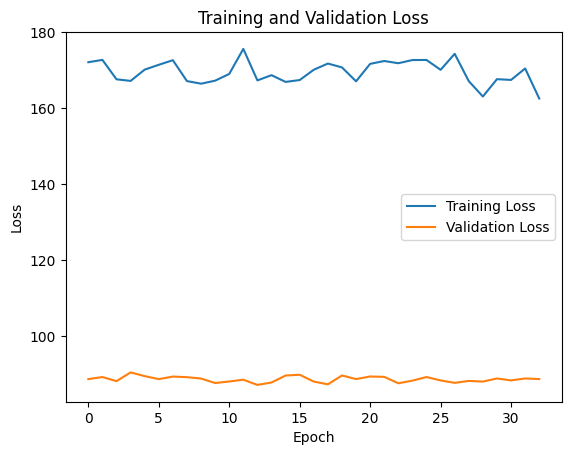

In [34]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [35]:
# Evaluate the model
test_loss, test_mae = model.evaluate(
    {"Transformer_Input": X_test_lstm, "CNN_Input": X_test_cwt},
    {"BP_Output": y_test_lstm}
)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


5/5 [==============================] - 1s 54ms/step - loss: 86.7829 - mae: 12.8577
Test Loss: 86.7829360961914, Test MAE: 12.857684135437012


5/5 [==============================] - 1s 53ms/step


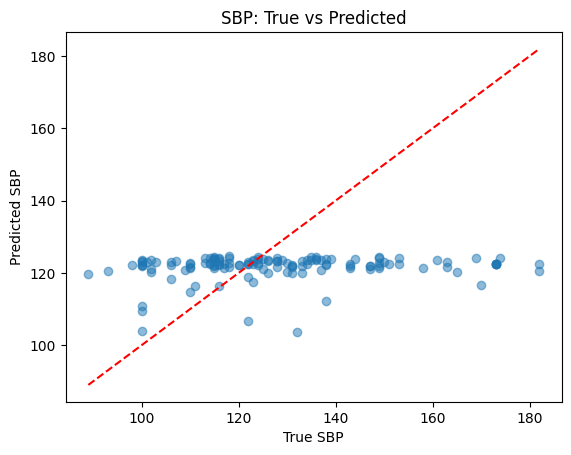

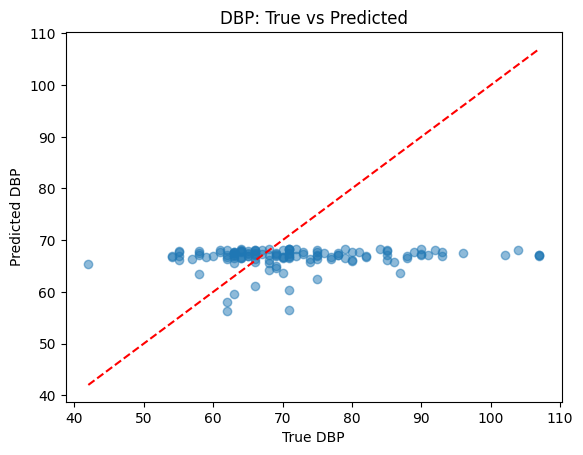

In [36]:
# Predict on test data
predictions = model.predict({"Transformer_Input": X_test_lstm, "CNN_Input": X_test_cwt})

# Compare predictions and true values
predicted_sbp = predictions[:, 0]
predicted_dbp = predictions[:, 1]
true_sbp = y_test_lstm[:, 0]
true_dbp = y_test_lstm[:, 1]

# Scatter plot
plt.scatter(true_sbp, predicted_sbp, alpha=0.5)
plt.plot([min(true_sbp), max(true_sbp)], [min(true_sbp), max(true_sbp)], color='red', linestyle='--')  # Add diagonal
plt.xlabel('True SBP')
plt.ylabel('Predicted SBP')
plt.title('SBP: True vs Predicted')
plt.show()

# Scatter plot for DBP
plt.scatter(true_dbp, predicted_dbp, alpha=0.5)
plt.plot([min(true_dbp), max(true_dbp)], [min(true_dbp), max(true_dbp)], color='red', linestyle='--')  # Add diagonal
plt.xlabel('True DBP')
plt.ylabel('Predicted DBP')
plt.title('DBP: True vs Predicted')
plt.show()



In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluate SBP
mae_sbp = mean_absolute_error(true_sbp, predicted_sbp)
mse_sbp = mean_squared_error(true_sbp, predicted_sbp)
print(f"SBP - MAE: {mae_sbp}, MSE: {mse_sbp}")

# Evaluate DBP
mae_dbp = mean_absolute_error(true_dbp, predicted_dbp)
mse_dbp = mean_squared_error(true_dbp, predicted_dbp)
print(f"DBP - MAE: {mae_dbp}, MSE: {mse_dbp}")


SBP - MAE: 16.39338545365767, MSE: 467.67110088810495
DBP - MAE: 9.321982990611684, MSE: 165.14439194768278


In [38]:
predicted_sbp

array([120.26616 , 117.57794 , 124.15376 , 124.32762 , 121.21345 ,
       123.94368 , 116.47811 , 122.333084, 122.57267 , 122.57052 ,
       124.148415, 121.32068 , 124.00324 , 123.61415 , 122.83112 ,
       114.69131 , 122.87344 , 123.911354, 121.05543 , 122.80755 ,
       122.88375 , 122.38157 , 121.531334, 123.7892  , 121.49257 ,
       122.013756, 123.25078 , 124.65085 , 123.473595, 106.61618 ,
       120.28517 , 123.04541 , 124.10501 , 123.209984, 123.20408 ,
       122.535736, 123.50641 , 122.29281 , 122.59064 , 109.55578 ,
       123.91018 , 121.68455 , 121.49647 , 122.51568 , 120.59327 ,
       121.90371 , 123.486176, 123.08405 , 122.22853 , 122.43337 ,
       122.39101 , 124.0409  , 124.02551 , 122.5141  , 123.624176,
       120.44242 , 123.72509 , 118.42973 , 123.53211 , 118.905235,
       121.81482 , 121.41771 , 122.14114 , 122.42275 , 123.60336 ,
       103.862236, 123.95686 , 122.76497 , 122.63245 , 123.44473 ,
       112.35392 , 123.31517 , 124.42774 , 123.51069 , 122.163

In [39]:
predicted_dbp

array([66.343544, 64.18038 , 68.08469 , 68.23943 , 66.32616 , 68.01437 ,
       63.583134, 67.04475 , 67.12397 , 67.20398 , 68.14738 , 66.412415,
       68.07349 , 67.79245 , 67.62033 , 62.55108 , 67.303696, 68.0211  ,
       66.23711 , 67.284836, 67.328674, 67.05133 , 66.544044, 67.85424 ,
       66.46494 , 66.788765, 67.54415 , 68.35284 , 67.755585, 57.994408,
       65.79227 , 67.537384, 68.03574 , 67.47041 , 67.595085, 67.248764,
       67.72267 , 67.00292 , 67.12855 , 59.63189 , 67.92277 , 66.614815,
       66.57609 , 67.07154 , 65.92781 , 66.77012 , 67.85324 , 67.4482  ,
       67.010765, 67.08377 , 67.031166, 68.02408 , 67.97089 , 67.07168 ,
       67.92325 , 66.41459 , 68.02613 , 64.69155 , 67.689705, 64.96654 ,
       67.13085 , 66.48959 , 66.89769 , 66.98881 , 67.966064, 56.419876,
       68.1268  , 67.22015 , 67.14324 , 67.74899 , 61.207405, 67.63842 ,
       68.33999 , 67.79139 , 66.93662 , 65.574295, 66.38919 , 67.36797 ,
       67.03652 , 66.77448 , 67.7509  , 66.81667 , 